In [1]:
from ultralytics import YOLO
from pathlib import Path
import torch

DATA_YAML = r"C:\Final project 2\backend\datasets\data.yaml"
RUNS_DIR  = r"C:\Final project 2\backend\runs"

print("Torch:", torch.__version__, "| CUDA:", torch.version.cuda, "| GPU available:", torch.cuda.is_available())

device_arg = 0 if torch.cuda.is_available() else "cpu"

model = YOLO("yolov8n.pt")  # start small; switch to yolov8s/8m later

model.train(
    data=DATA_YAML,
    epochs=50,
    imgsz=640,
    batch=16,
    project=RUNS_DIR,
    name="yolo8n-fracture",
    device=device_arg,     # <-- auto-picks 0 or cpu
    deterministic=True
)


WARNING  Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\aadit\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Torch: 2.8.0+cu129 | CUDA: 12.9 | GPU available: True
Ultralytics 8.3.0  Python-3.10.18 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 5070 Laptop GPU, 8151MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Final project 2\backend\datasets\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=C:\Final project 2\backend\runs, name=yolo8n-fracture6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=Fa

train: Scanning C:\Final Project\bone_fracture_detection\datasets\roboflow_yolo\train\labels.cache... 1347 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1347/1347 [00:00<?, ?it/s]
val: Scanning C:\Final Project\bone_fracture_detection\datasets\roboflow_yolo\valid\labels.cache... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to C:\Final project 2\backend\runs\yolo8n-fracture6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Final project 2\backend\runs\yolo8n-fracture6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.42G      2.527      5.647      2.346          4        640: 100%|██████████| 85/85 [00:23<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        128        157    0.00171      0.314     0.0259    0.00722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.42G      2.158      4.606      1.947          8        640: 100%|██████████| 85/85 [00:11<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

                   all        128        157      0.776     0.0187      0.045      0.019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.42G      2.119      4.185      1.933          3        640: 100%|██████████| 85/85 [00:11<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

                   all        128        157      0.565     0.0665     0.0496     0.0206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.42G      2.059      3.736      1.875          8        640: 100%|██████████| 85/85 [00:10<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

                   all        128        157       0.61       0.13      0.102     0.0396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.43G      2.006      3.318      1.827          7        640: 100%|██████████| 85/85 [00:10<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

                   all        128        157      0.635      0.151      0.191     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.43G      1.956      3.063       1.78          3        640: 100%|██████████| 85/85 [00:10<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]

                   all        128        157      0.808      0.122      0.166     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.42G      1.905      2.778      1.735          6        640: 100%|██████████| 85/85 [00:11<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

                   all        128        157      0.702      0.178       0.19     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.42G      1.886      2.659       1.72          4        640: 100%|██████████| 85/85 [00:11<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

                   all        128        157      0.489      0.251      0.336      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.43G      1.827      2.376       1.66          7        640: 100%|██████████| 85/85 [00:10<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

                   all        128        157       0.65      0.306      0.323      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.42G      1.787      2.255      1.616          2        640: 100%|██████████| 85/85 [00:09<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        128        157      0.597      0.264      0.331      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.42G      1.805      2.133       1.65          8        640: 100%|██████████| 85/85 [00:09<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        128        157      0.882      0.253      0.421      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.41G      1.734       2.01      1.574          4        640: 100%|██████████| 85/85 [00:09<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

                   all        128        157      0.521      0.489      0.488      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.42G      1.728      1.926      1.594          2        640: 100%|██████████| 85/85 [00:09<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

                   all        128        157      0.541      0.551      0.512      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.43G      1.715      1.862      1.572          5        640: 100%|██████████| 85/85 [00:09<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        128        157      0.599      0.552      0.554      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.42G      1.671      1.736      1.522          3        640: 100%|██████████| 85/85 [00:09<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

                   all        128        157      0.753      0.546      0.608      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.41G      1.646      1.675      1.496          7        640: 100%|██████████| 85/85 [00:09<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.18it/s]

                   all        128        157      0.645      0.476      0.515      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.42G      1.609      1.599      1.487          6        640: 100%|██████████| 85/85 [00:09<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]

                   all        128        157      0.837      0.476      0.636      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.43G      1.622      1.566      1.497          4        640: 100%|██████████| 85/85 [00:09<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.77it/s]

                   all        128        157      0.537      0.702      0.615      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.43G       1.58      1.516      1.476          4        640: 100%|██████████| 85/85 [00:09<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        128        157      0.781      0.658      0.719      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.42G      1.575      1.491      1.469          5        640: 100%|██████████| 85/85 [00:09<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.76it/s]

                   all        128        157      0.805      0.579      0.693      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.42G      1.538      1.415      1.429          7        640: 100%|██████████| 85/85 [00:09<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]

                   all        128        157       0.87      0.559      0.728      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.43G      1.534      1.413      1.431          4        640: 100%|██████████| 85/85 [00:09<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

                   all        128        157      0.687      0.624      0.702      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.42G      1.537      1.363      1.426          7        640: 100%|██████████| 85/85 [00:09<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

                   all        128        157      0.758      0.653      0.728      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.42G      1.508      1.304      1.401          5        640: 100%|██████████| 85/85 [00:09<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]

                   all        128        157      0.692      0.673      0.748      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.42G       1.49      1.275      1.386          3        640: 100%|██████████| 85/85 [00:09<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all        128        157      0.626      0.722       0.73      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.42G       1.46      1.235      1.352          3        640: 100%|██████████| 85/85 [00:09<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

                   all        128        157      0.701      0.729      0.832      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.42G      1.469      1.228       1.39          3        640: 100%|██████████| 85/85 [00:09<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]

                   all        128        157      0.847      0.676      0.816      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.41G      1.446       1.17      1.347         11        640: 100%|██████████| 85/85 [00:09<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.68it/s]

                   all        128        157      0.769       0.73      0.809      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.42G      1.419      1.137      1.352          3        640: 100%|██████████| 85/85 [00:09<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]

                   all        128        157      0.845      0.756      0.852       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.43G       1.41      1.119      1.329          9        640: 100%|██████████| 85/85 [00:09<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        128        157      0.839      0.788      0.858       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.42G      1.435      1.118      1.346          4        640: 100%|██████████| 85/85 [00:09<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all        128        157      0.887      0.798      0.867      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.42G      1.385      1.088      1.323          7        640: 100%|██████████| 85/85 [00:09<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]

                   all        128        157      0.813      0.808      0.831      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.43G      1.364       1.05      1.307          4        640: 100%|██████████| 85/85 [00:09<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        128        157      0.768      0.858      0.822      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.42G      1.344      1.021      1.286          7        640: 100%|██████████| 85/85 [00:09<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]

                   all        128        157      0.899      0.758      0.864      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.42G      1.349      1.038        1.3          4        640: 100%|██████████| 85/85 [00:09<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]

                   all        128        157      0.728      0.794      0.788      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.42G      1.312      1.003      1.269          6        640: 100%|██████████| 85/85 [00:09<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        128        157      0.949      0.846      0.898      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.41G      1.318      1.012      1.275          5        640: 100%|██████████| 85/85 [00:09<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]

                   all        128        157      0.965      0.828      0.898      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.43G       1.32      0.982      1.281          9        640: 100%|██████████| 85/85 [00:09<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

                   all        128        157      0.851      0.831      0.884      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.43G      1.289     0.9427      1.256          4        640: 100%|██████████| 85/85 [00:10<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]

                   all        128        157      0.865       0.77      0.849      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.41G      1.289     0.9265      1.252         10        640: 100%|██████████| 85/85 [00:09<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]

                   all        128        157      0.845      0.817      0.866      0.449


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.41G      1.234     0.7802      1.292          3        640: 100%|██████████| 85/85 [00:09<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]

                   all        128        157       0.83      0.843      0.854      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.41G      1.195      0.754       1.26          3        640: 100%|██████████| 85/85 [00:09<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

                   all        128        157      0.885       0.79      0.861      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.41G      1.182     0.6969      1.242          5        640: 100%|██████████| 85/85 [00:09<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

                   all        128        157      0.842      0.839      0.868      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.39G       1.17     0.6874      1.256          4        640: 100%|██████████| 85/85 [00:09<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

                   all        128        157      0.832      0.852       0.87      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.41G      1.131     0.6739      1.219          3        640: 100%|██████████| 85/85 [00:09<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        128        157      0.904      0.846      0.896      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.41G      1.139     0.6664      1.227          3        640: 100%|██████████| 85/85 [00:09<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.49it/s]

                   all        128        157       0.88      0.837      0.892      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.4G      1.123      0.662      1.213          3        640: 100%|██████████| 85/85 [00:09<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

                   all        128        157      0.872      0.847      0.891      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.39G      1.109      0.646      1.206          3        640: 100%|██████████| 85/85 [00:09<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.46it/s]

                   all        128        157      0.949      0.854      0.901      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.41G      1.077     0.6391      1.201          3        640: 100%|██████████| 85/85 [00:09<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.49it/s]

                   all        128        157      0.927      0.851      0.889      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.41G      1.069     0.6292      1.188          2        640: 100%|██████████| 85/85 [00:09<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.49it/s]

                   all        128        157      0.897      0.855      0.883      0.459



50 epochs completed in 0.165 hours.
Optimizer stripped from C:\Final project 2\backend\runs\yolo8n-fracture6\weights\last.pt, 5.6MB
Optimizer stripped from C:\Final project 2\backend\runs\yolo8n-fracture6\weights\best.pt, 5.6MB

Validating C:\Final project 2\backend\runs\yolo8n-fracture6\weights\best.pt...
Ultralytics 8.3.0  Python-3.10.18 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 5070 Laptop GPU, 8151MiB)
Model summary (fused): 186 layers, 2,686,318 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


                   all        128        157      0.851      0.831      0.885      0.469
            Comminuted         15         15      0.972      0.733      0.819      0.442
            Greenstick         10         10       0.77        0.5      0.518      0.195
               Healthy          7          7      0.823          1      0.995      0.682
                Linear          1          1      0.821          1      0.995      0.398
     Oblique Displaced         30         30          1      0.861      0.929      0.465
               Oblique          7          7      0.919      0.714      0.869      0.557
             Segmental          3          3      0.578          1      0.995      0.708
                Spiral          5          5      0.792      0.767      0.895       0.44
  Transverse Displaced         53         65      0.882      0.738      0.842      0.355
            Transverse         11         14      0.953          1      0.995      0.448
Speed: 0.4ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000023A490682B0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

In [2]:
import torch, sys
print("Exe:", sys.executable)
print("Torch:", torch.__version__, "CUDA:", torch.version.cuda, "Available:", torch.cuda.is_available())
print("Devices:", torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU-only")


Exe: c:\Users\aadit\anaconda3\envs\fxdetector\python.exe
Torch: 2.8.0+cu129 CUDA: 12.9 Available: True
Devices: 1
NVIDIA GeForce RTX 5070 Laptop GPU


✅ Model loaded from: C:\Final project 2\backend\runs\yolo8n-fracture6\weights\best.pt
Ultralytics 8.3.0  Python-3.10.18 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 5070 Laptop GPU, 8151MiB)
Model summary (fused): 186 layers, 2,686,318 parameters, 0 gradients, 6.8 GFLOPs


val: Scanning C:\Final Project\bone_fracture_detection\datasets\roboflow_yolo\valid\labels.cache... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


                   all        128        157      0.879       0.87      0.915      0.501
            Comminuted         15         15          1      0.733      0.867      0.523
            Greenstick         10         10      0.895        0.6      0.749      0.262
               Healthy          7          7      0.801          1      0.995      0.704
                Linear          1          1          1          1      0.995      0.398
     Oblique Displaced         30         30      0.994      0.867      0.934      0.496
               Oblique          7          7      0.909      0.714      0.875      0.577
             Segmental          3          3      0.556          1      0.995      0.711
                Spiral          5          5      0.828          1      0.895      0.455
  Transverse Displaced         53         65      0.879      0.785       0.85        0.4
            Transverse         11         14      0.929          1      0.995      0.482
Speed: 1.4ms preproce

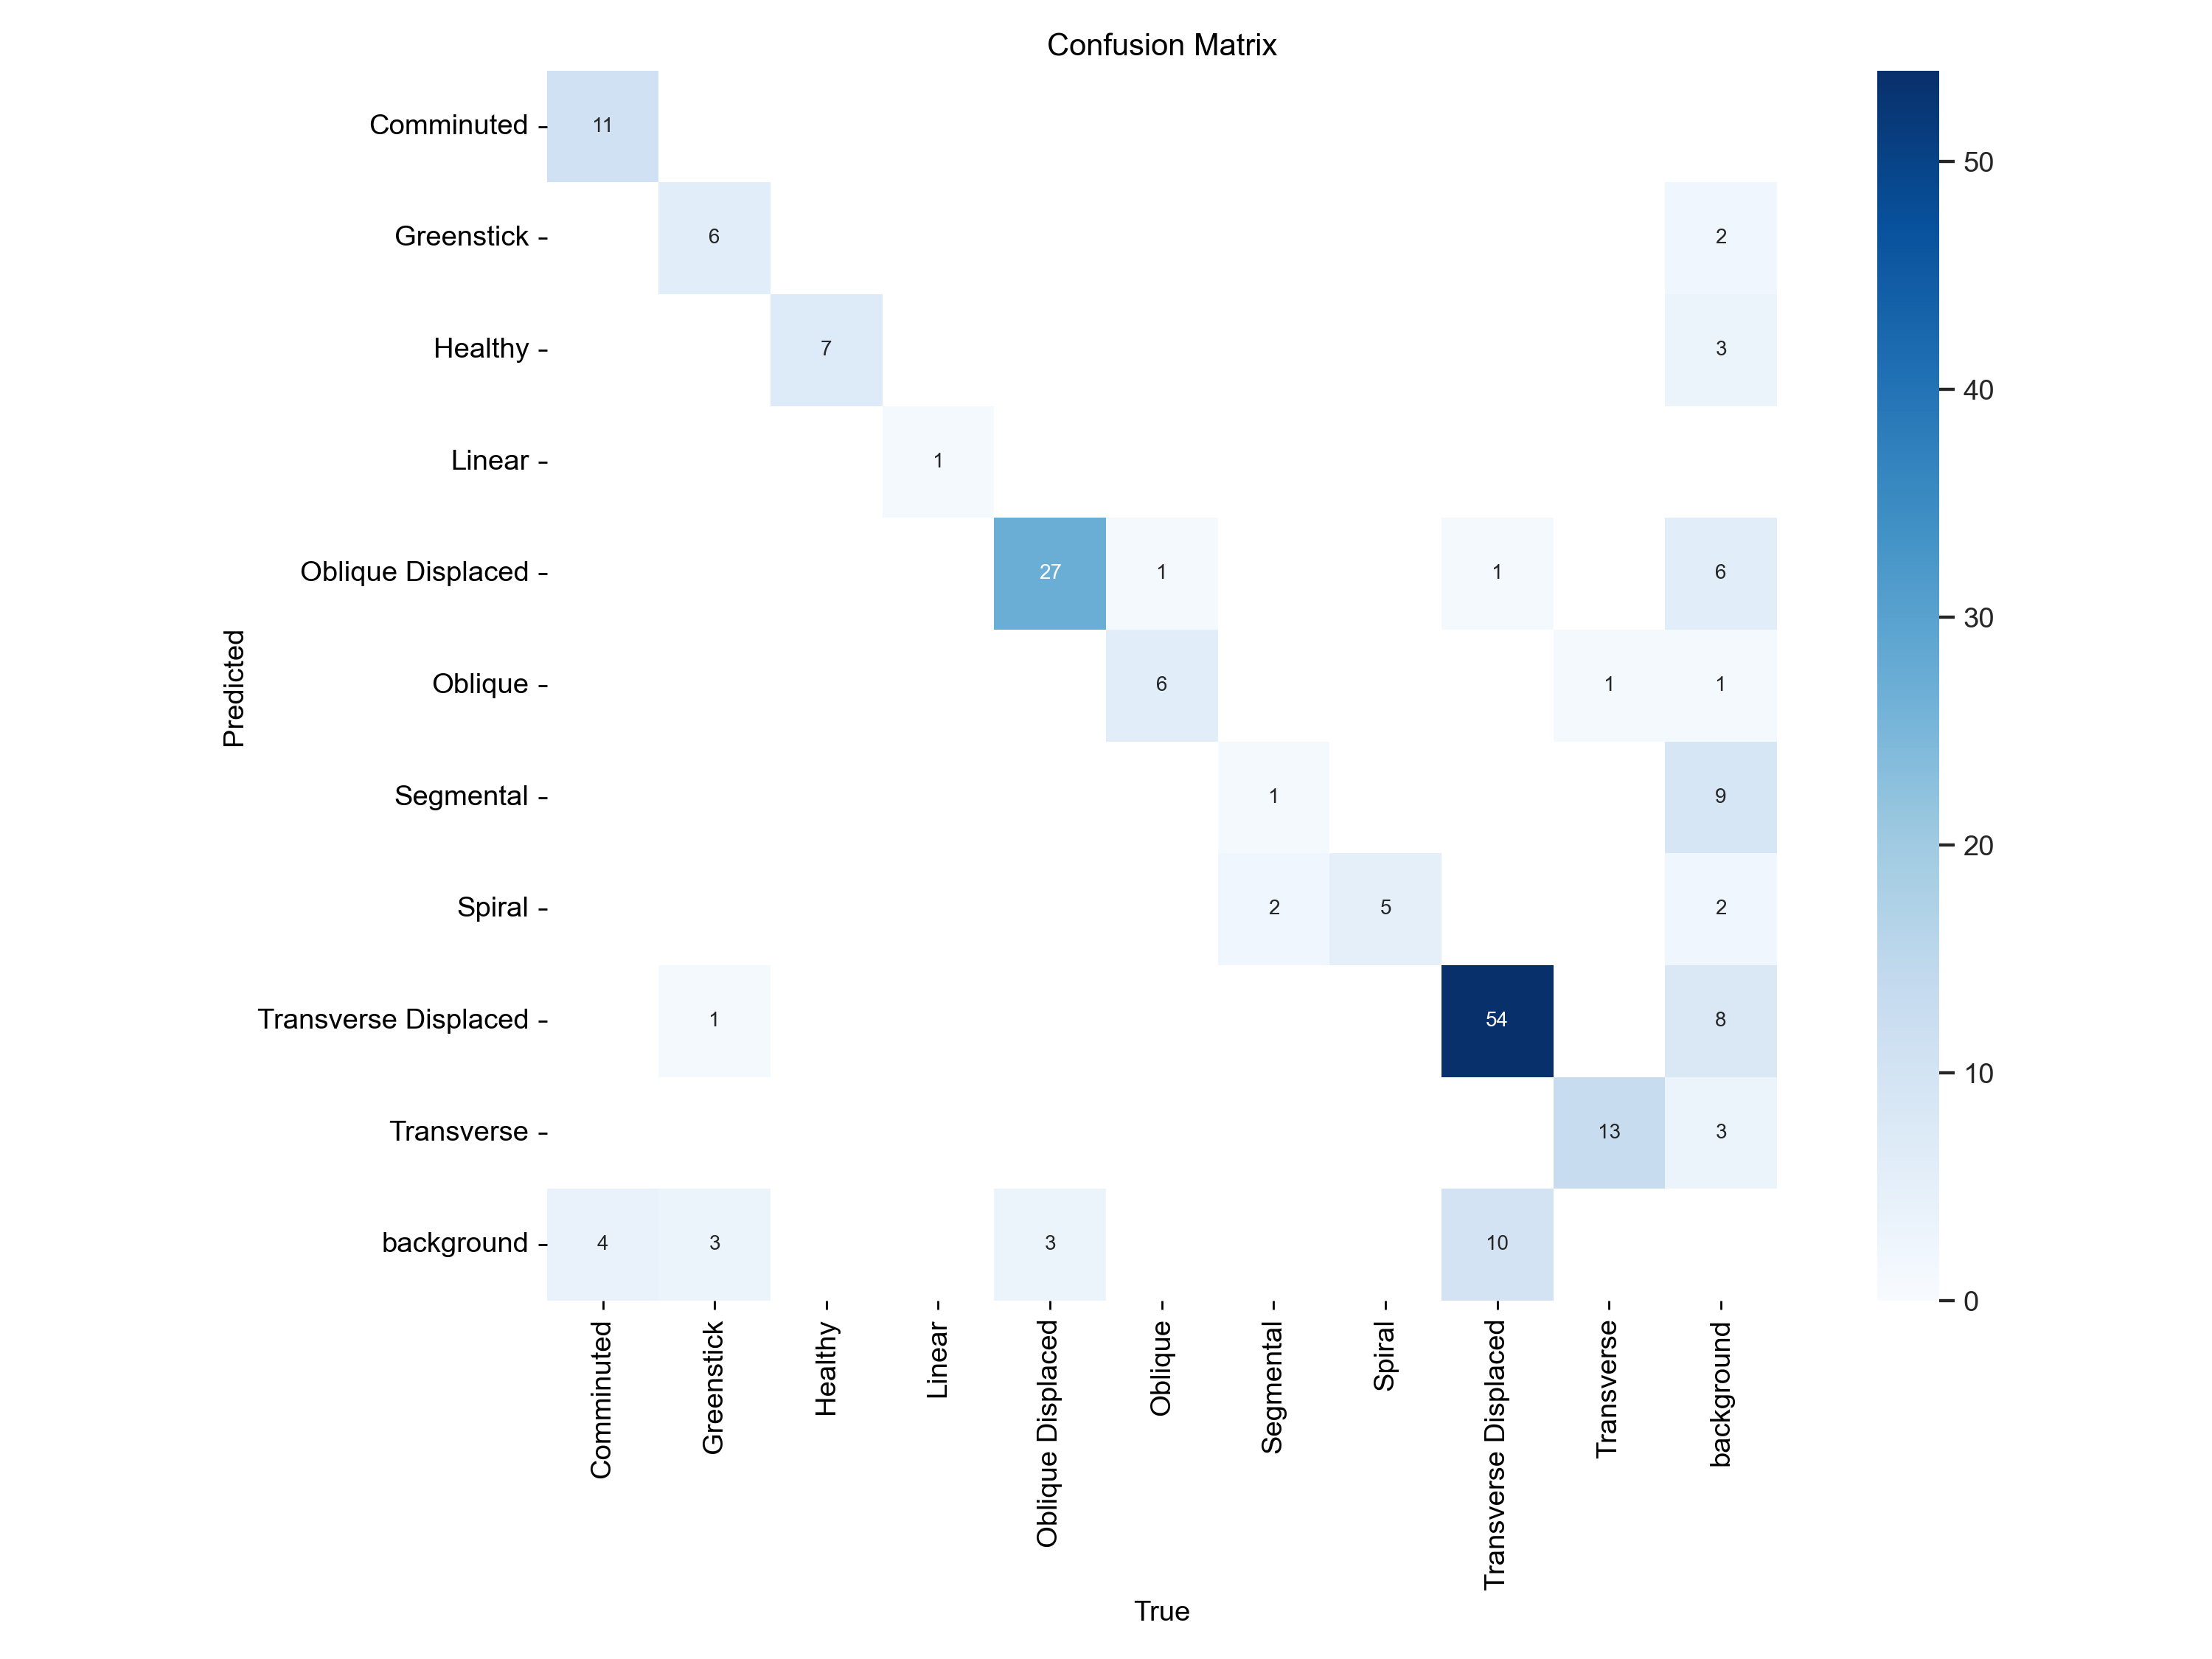

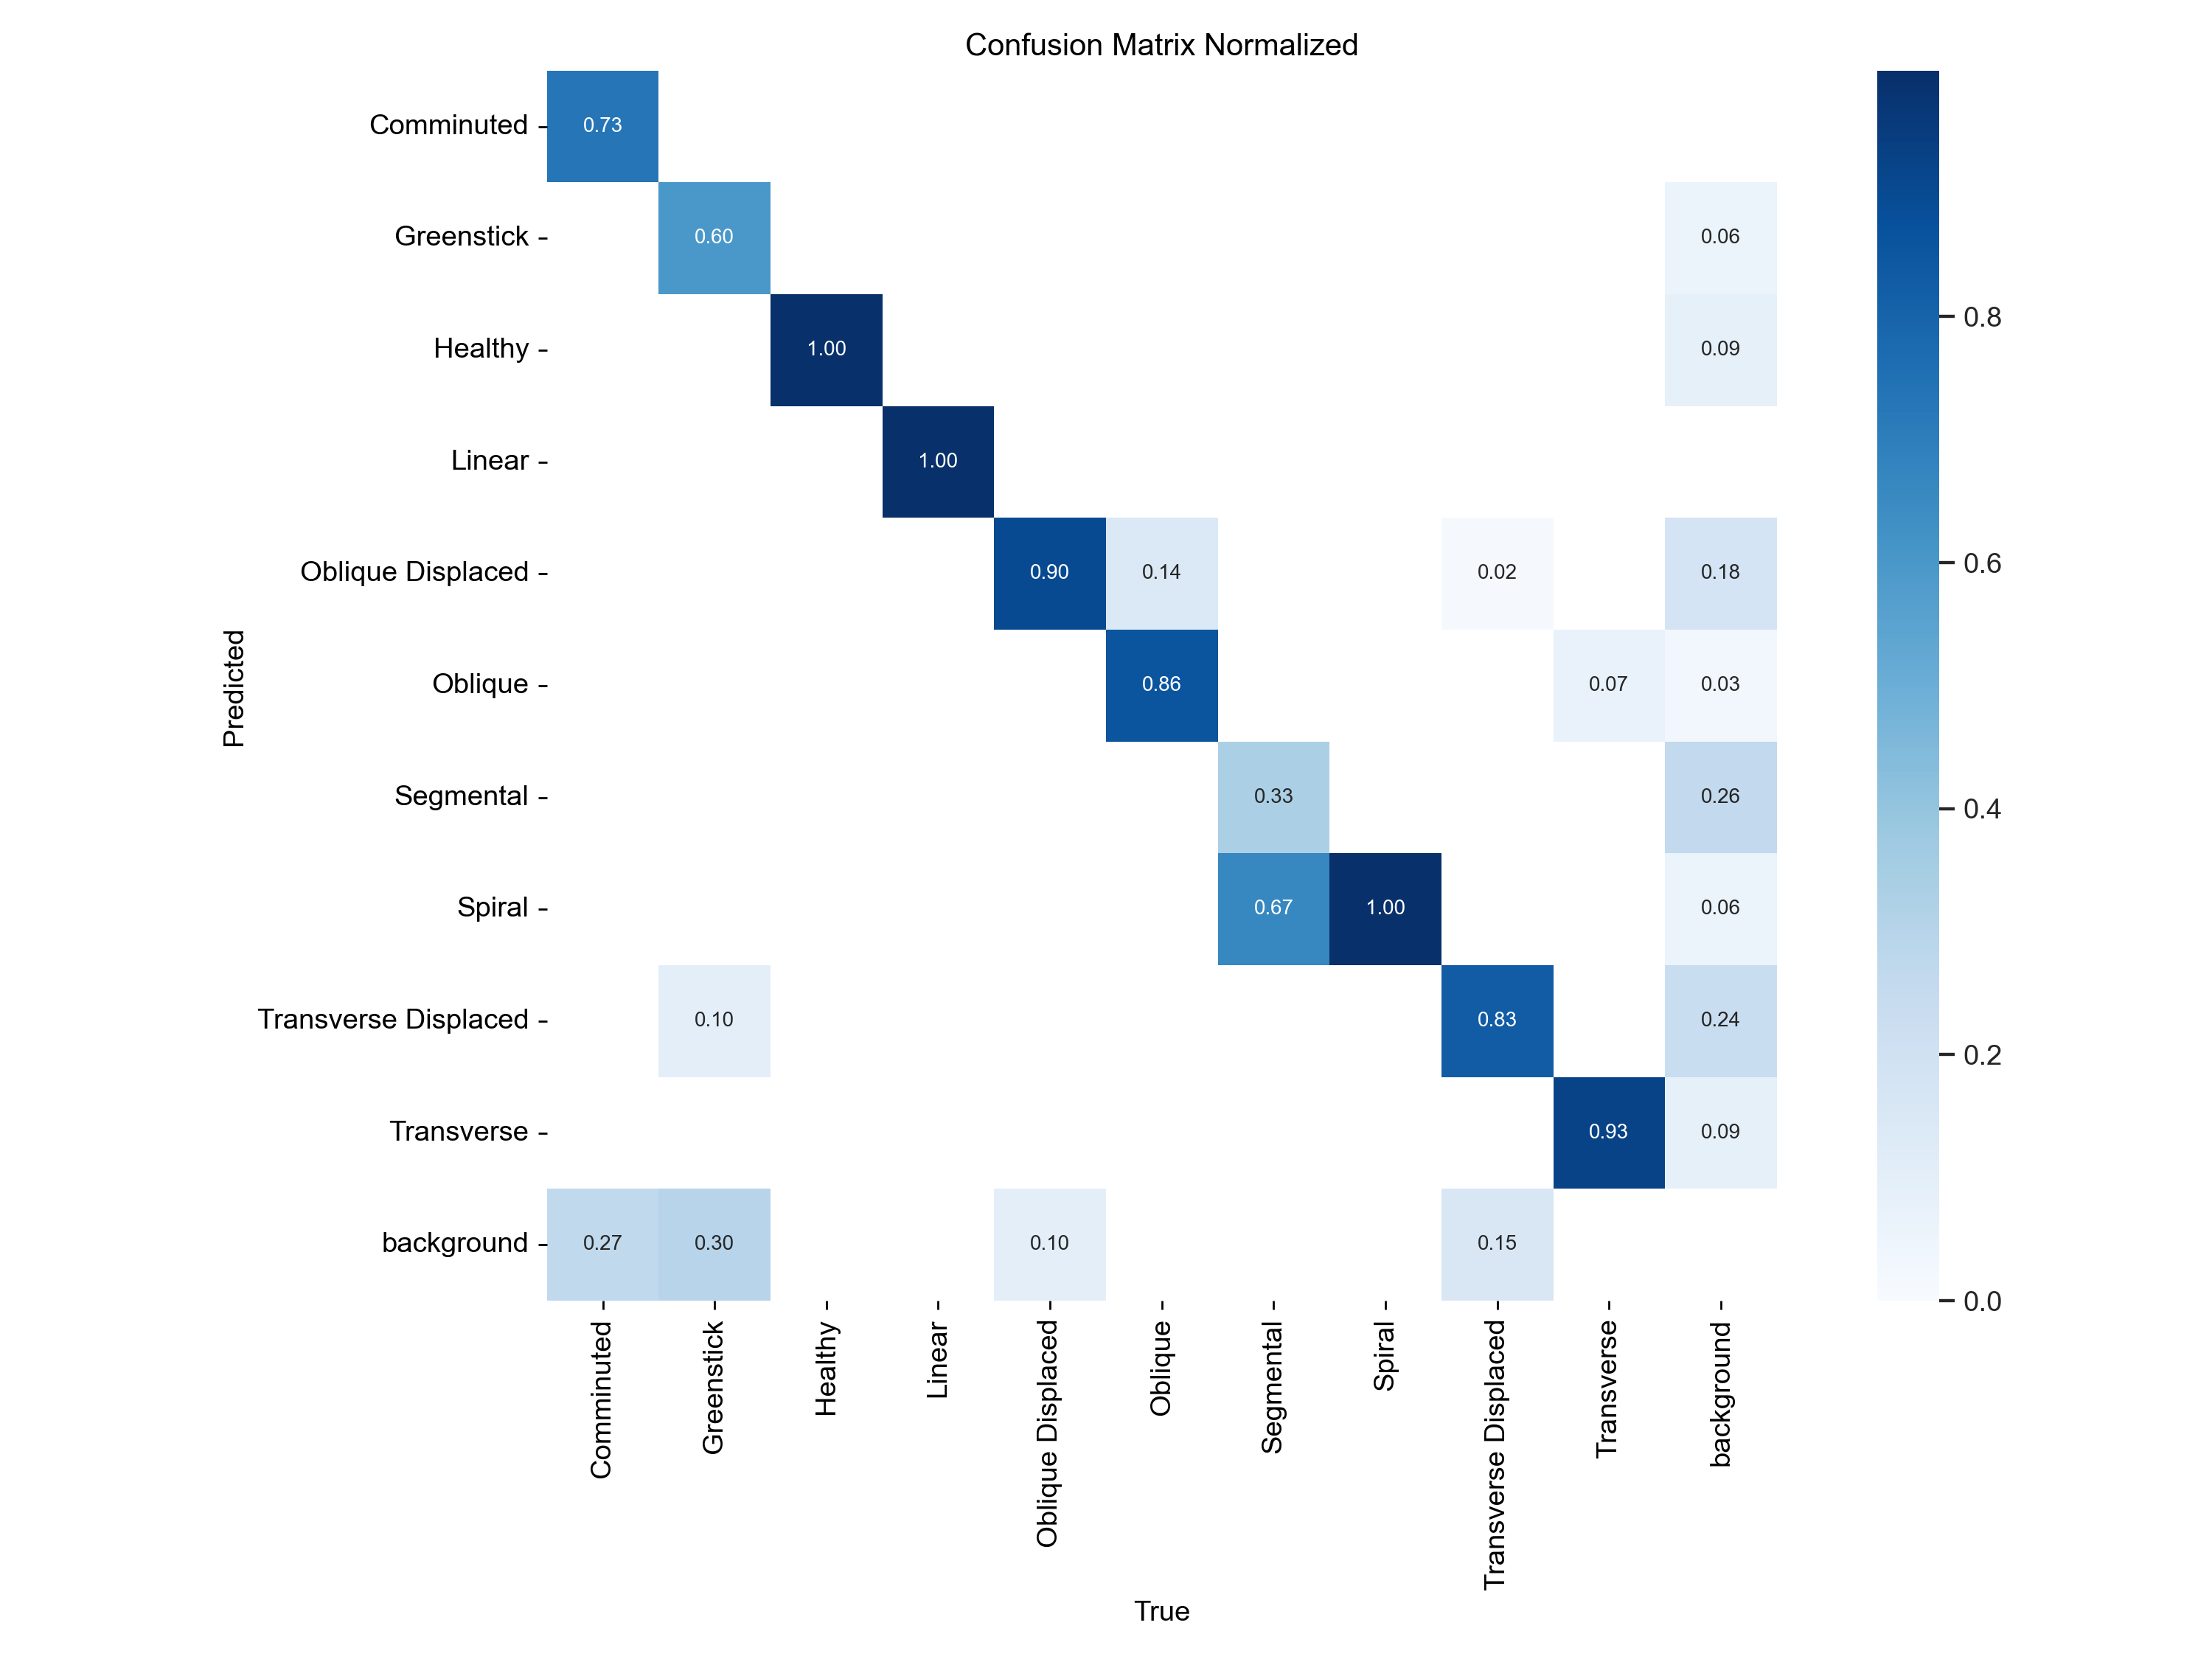

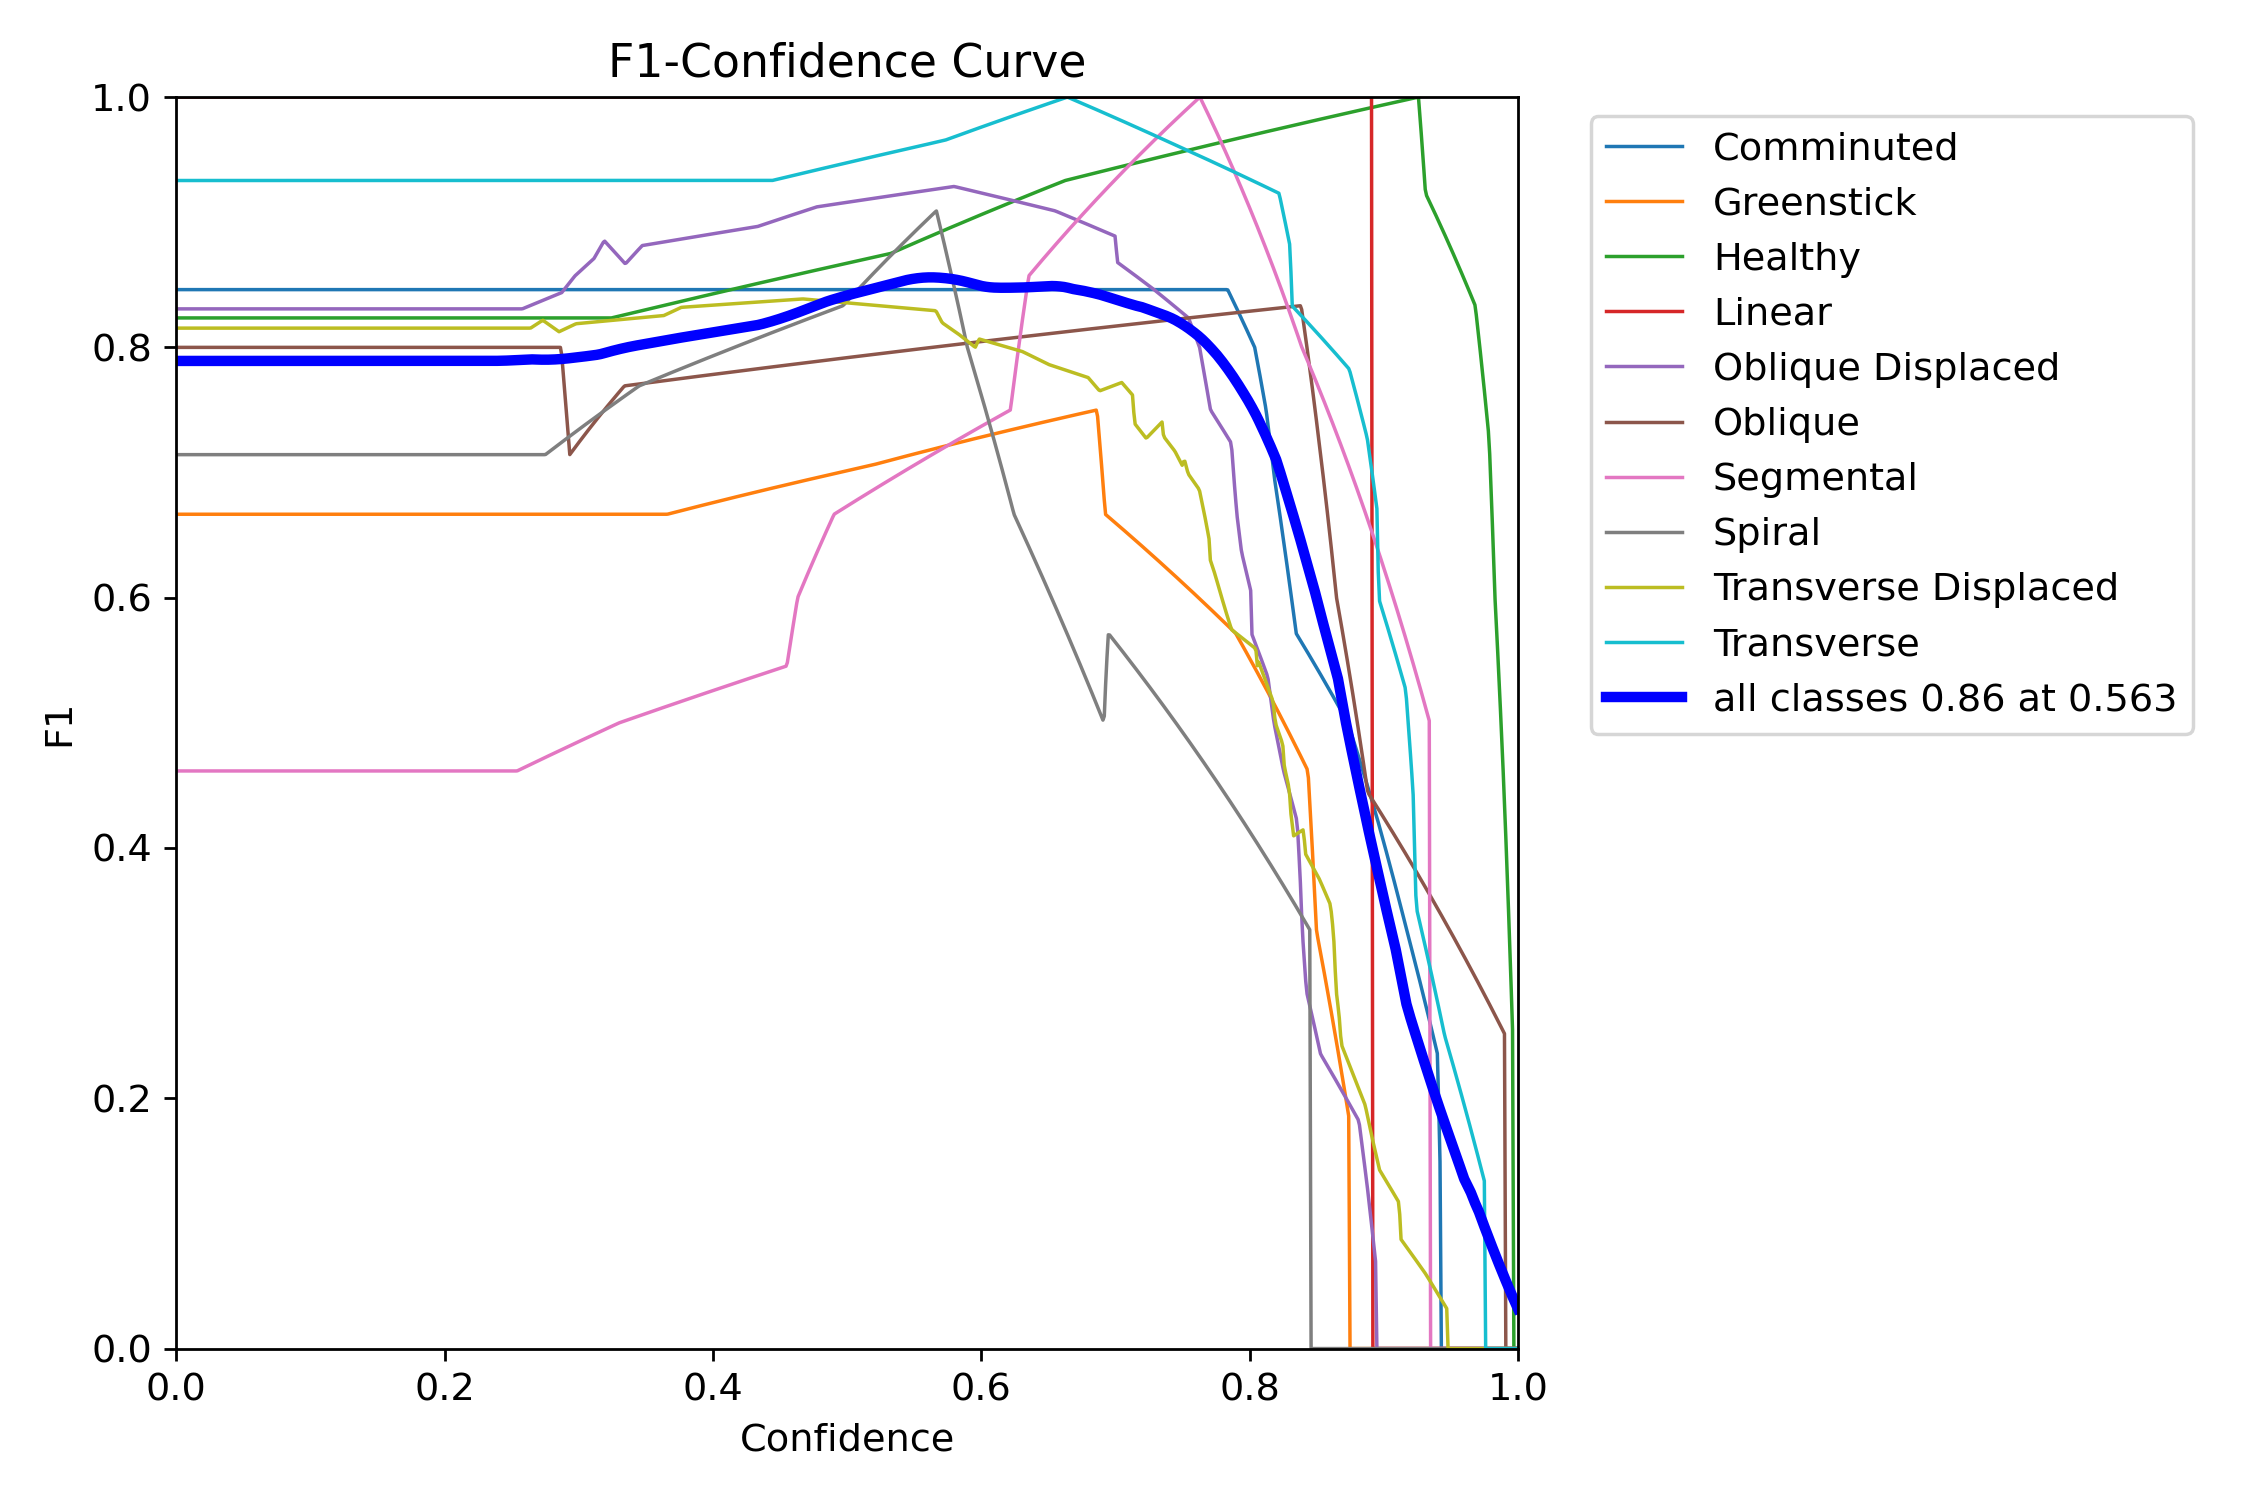

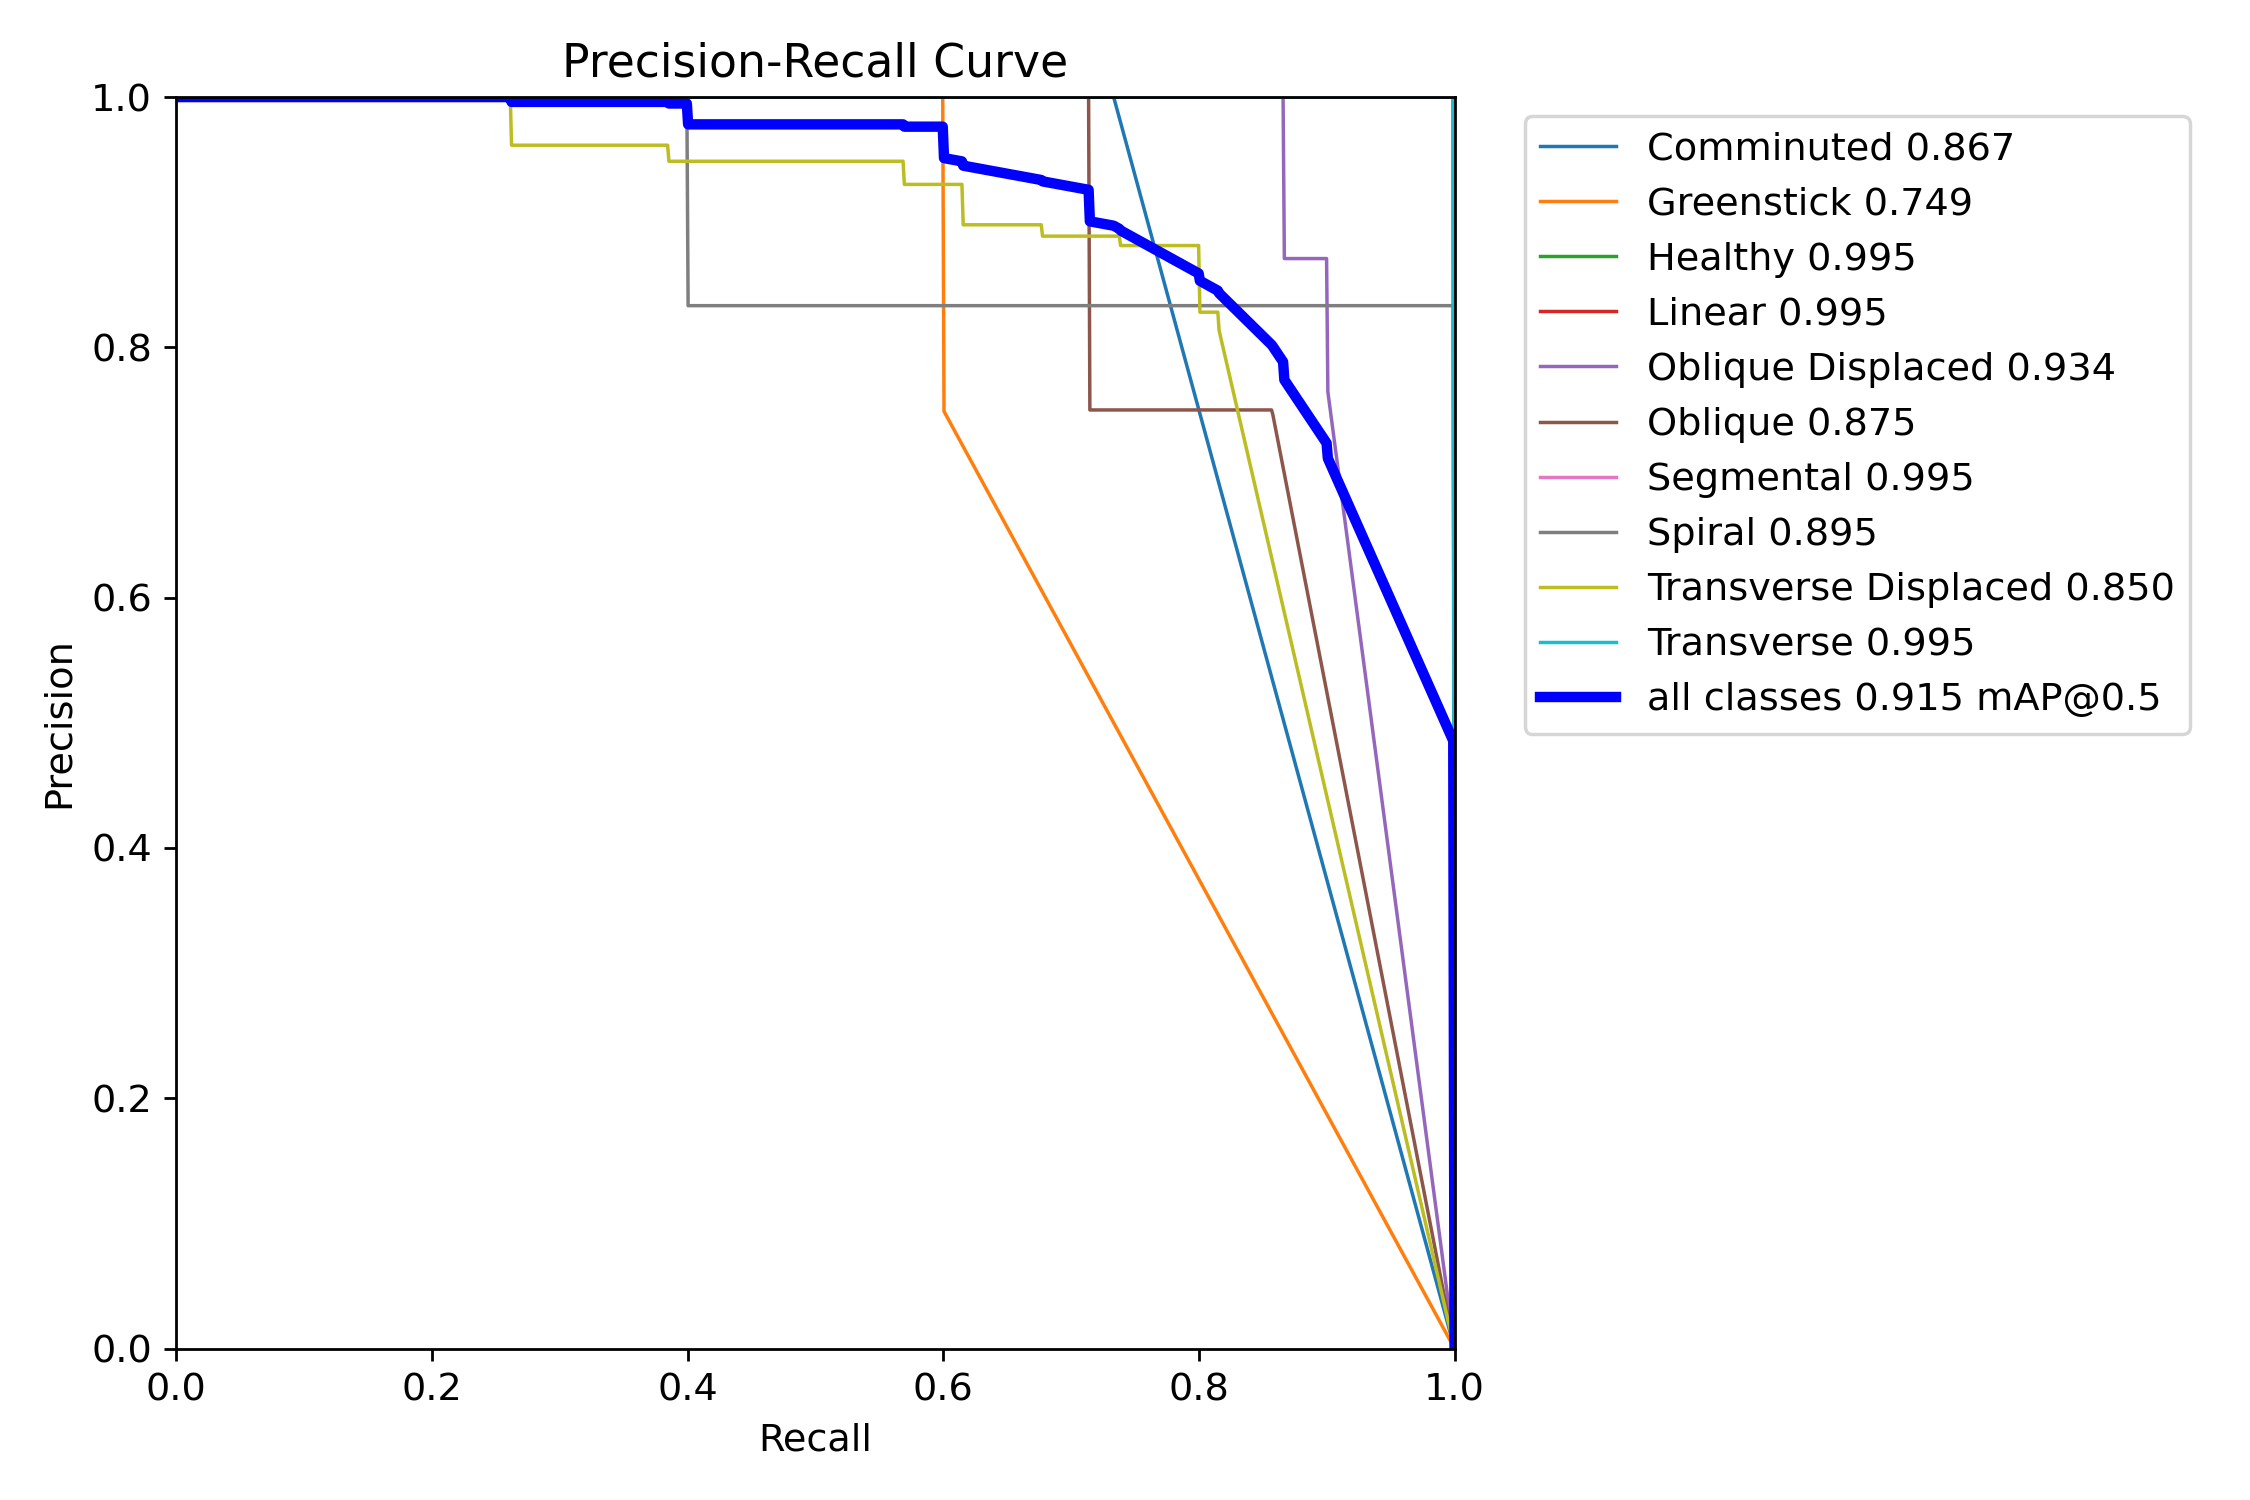

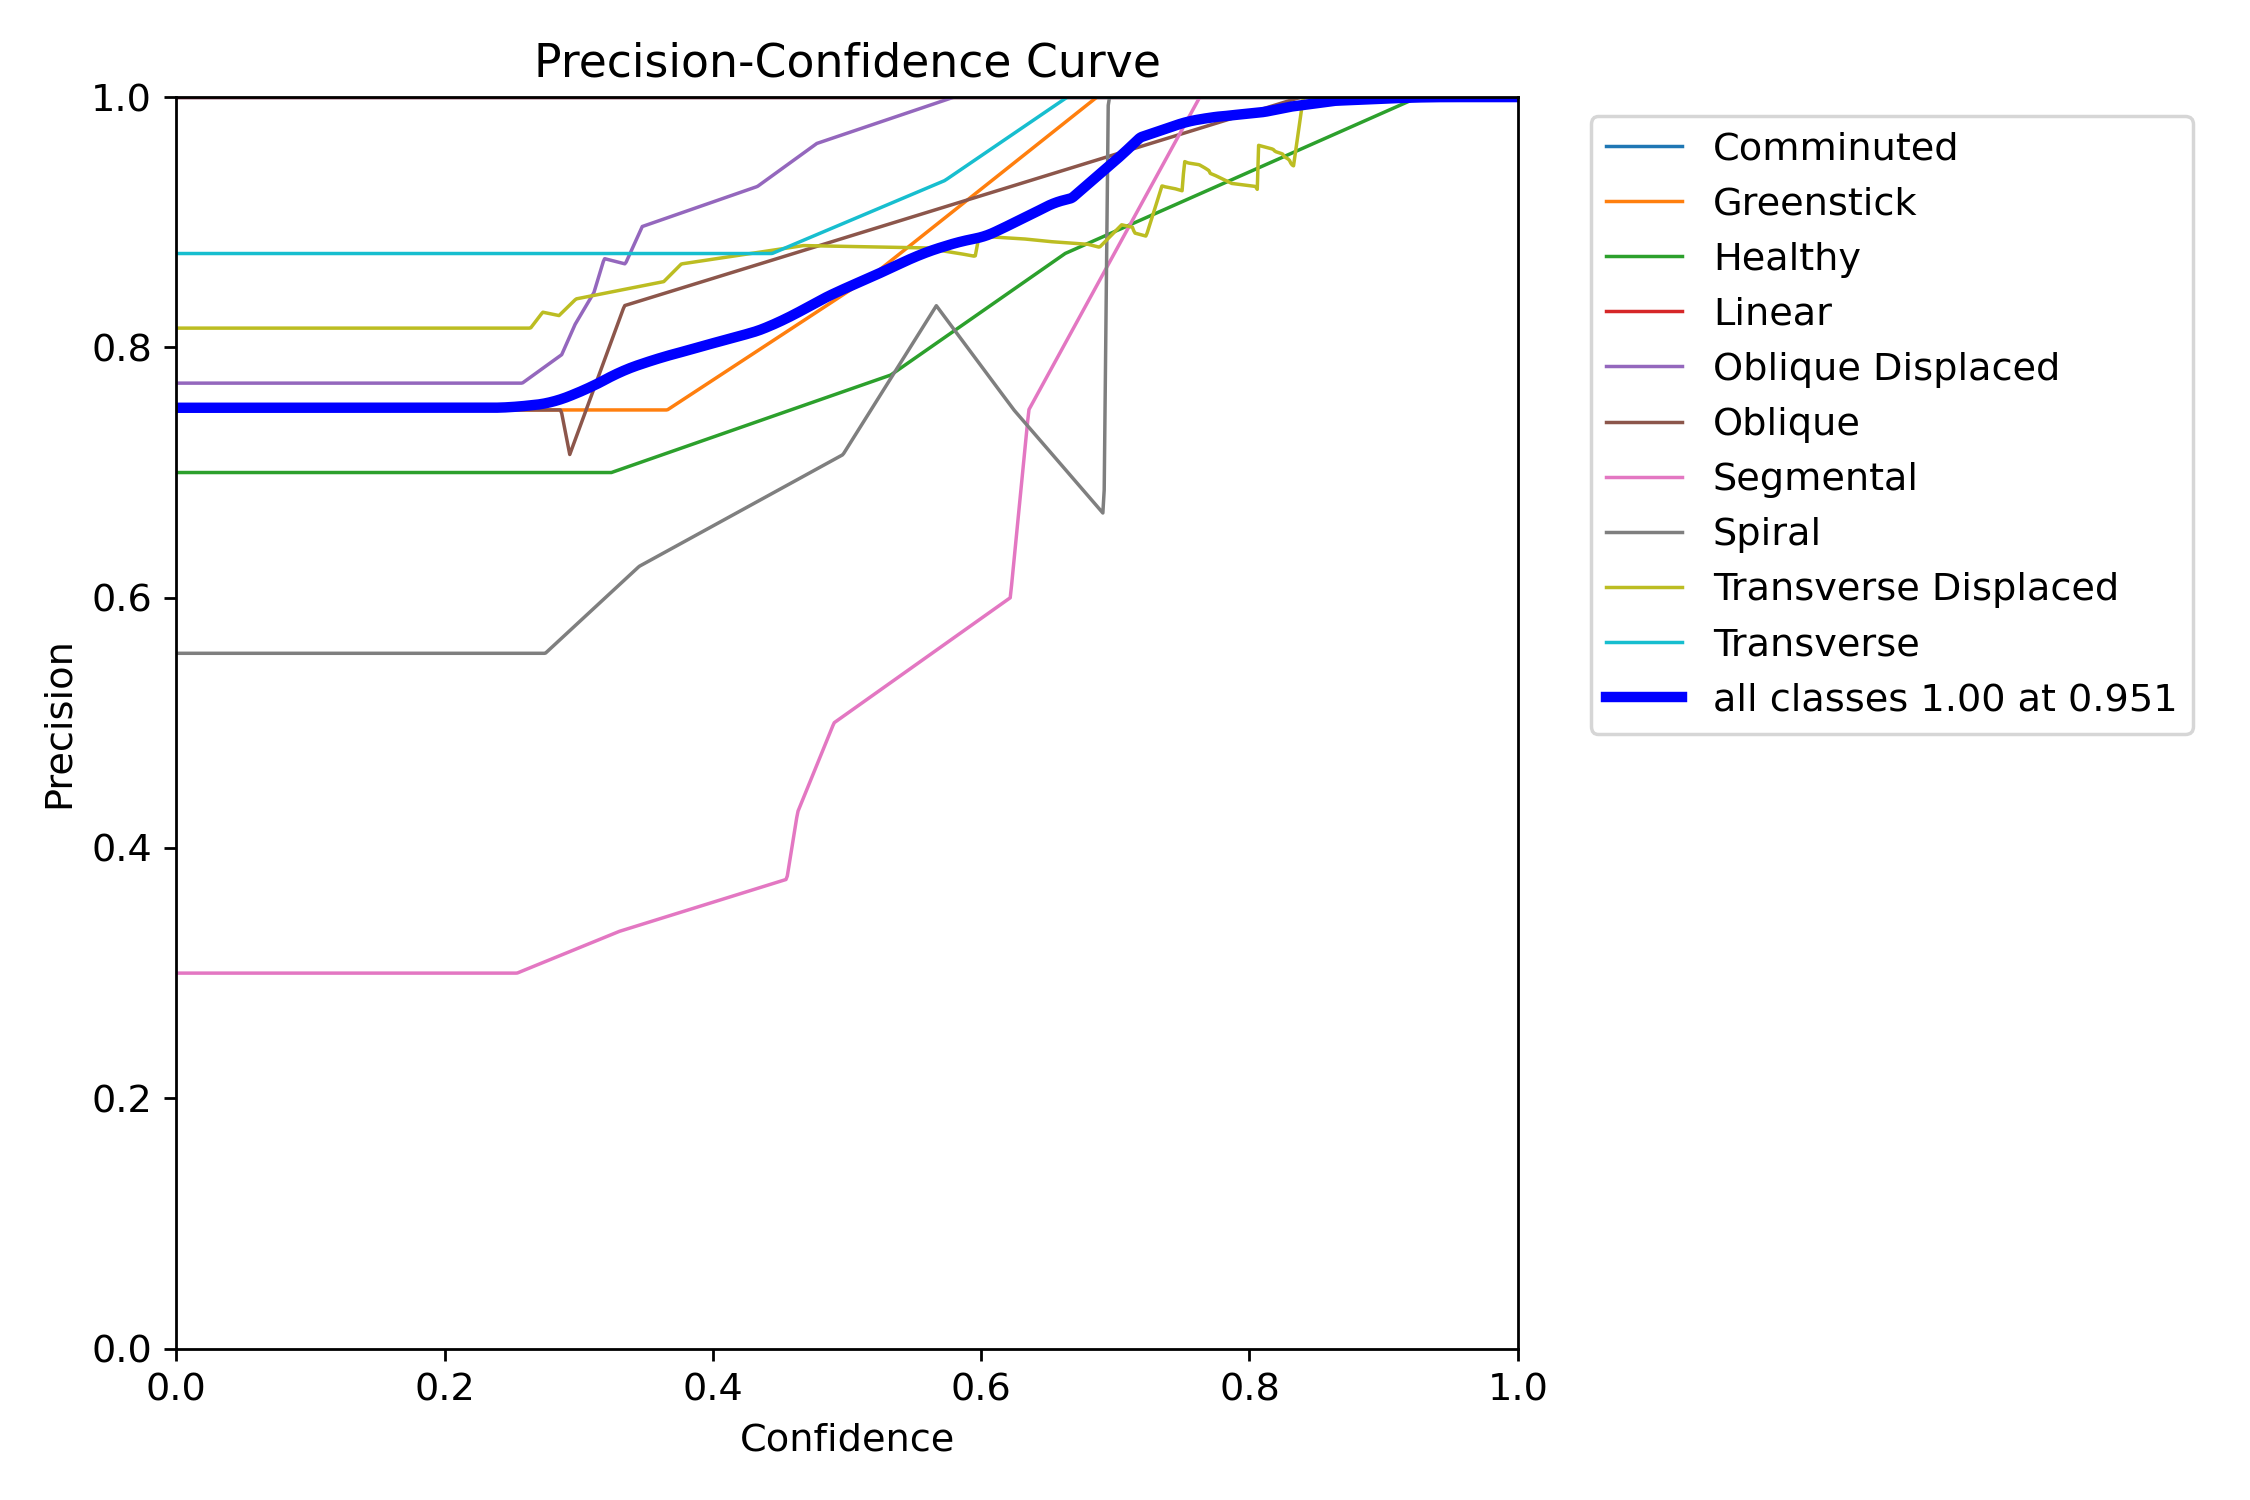

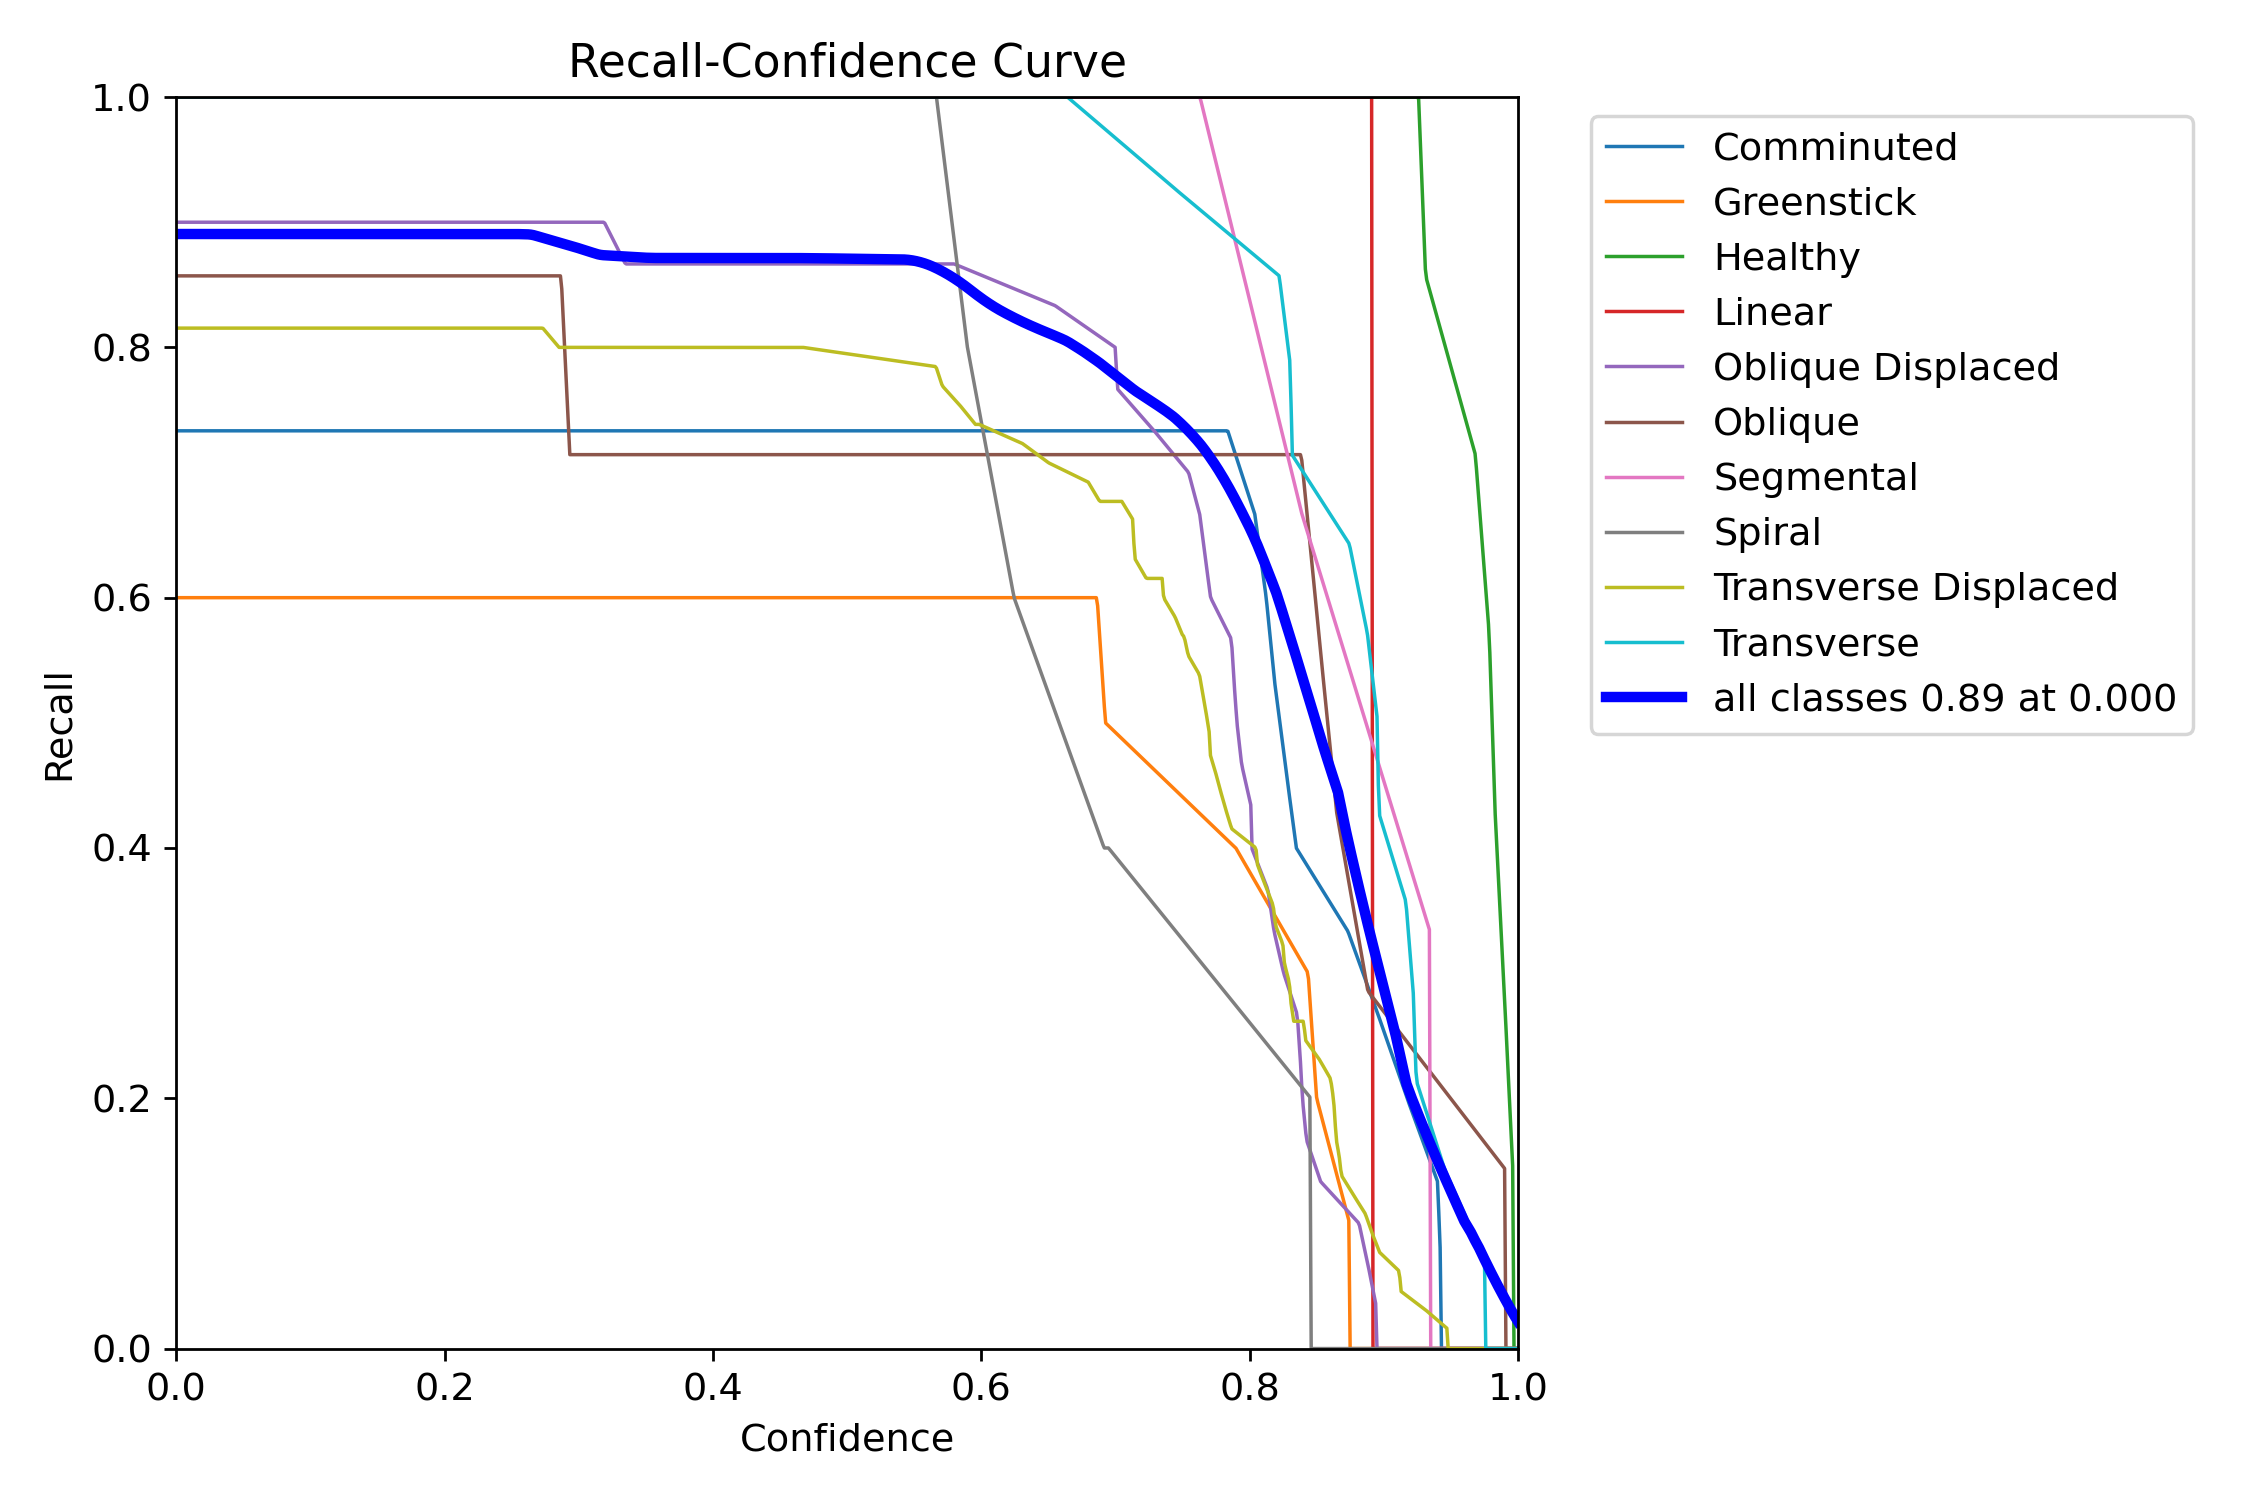

In [6]:
# --- 02_export_and_validate.ipynb ---
from ultralytics import YOLO
from pathlib import Path

# === Paths ===
BASE_DIR = Path(r"C:\Final project 2\backend")
MODEL_PT = BASE_DIR / "models" / "best.pt"      # or your runs/.../weights/best.pt
EXPORT_DIR = BASE_DIR / "models" / "exported"
DATA_YAML = BASE_DIR / "datasets" / "data.yaml" # make sure it points to train/val/test dirs
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# === Load model ===
MODEL_PT = BASE_DIR / "runs" / "yolo8n-fracture6" / "weights" / "best.pt"

print("✅ Model loaded from:", MODEL_PT)

# === Validate on the validation set ===
results = model.val(
    data=str(DATA_YAML),
    imgsz=640,
    conf=0.25,
    device=0,        # GPU
    plots=True,
    save_json=True
)

# --- Print summary ---
print("\n📊 Validation summary:")
print(f"Precision(B): {results.results_dict['metrics/precision(B)']:.3f}")
print(f"Recall(B):    {results.results_dict['metrics/recall(B)']:.3f}")
print(f"mAP50(B):     {results.results_dict['metrics/mAP50(B)']:.3f}")
print(f"mAP50–95(B):  {results.results_dict['metrics/mAP50-95(B)']:.3f}")
print(f"Fitness:      {results.results_dict['fitness']:.3f}")

# === Export to ONNX and TorchScript for deployment ===
print("\n🧩 Exporting model formats (ONNX + TorchScript)...")
model.export(format="onnx", dynamic=True, opset=12, imgsz=640, half=False, optimize=True)
model.export(format="torchscript", imgsz=640)

print("\n✅ Export complete. Files saved under:")
for f in (BASE_DIR / "models").glob("*.*"):
    if f.suffix in [".onnx", ".pt", ".torchscript"]:
        print(" ", f.name)

# === Quick test on 1–2 validation images ===
TEST_IMG_DIR = BASE_DIR / "datasets" / "valid" / "images"
preds = model.predict(source=str(TEST_IMG_DIR), imgsz=640, conf=0.25, save=True, device=0)
print(f"\n✅ Saved predictions to: {preds[0].save_dir}")

# Show plots in notebook (optional)
from IPython.display import Image, display
result_plots = list(Path(results.save_dir).glob("*.png"))
if result_plots:
    print("\n📈 Validation plots:")
    for p in result_plots:
        display(Image(filename=str(p)))
